# NBA Teams Mutual Players

I always like to play a game when watching NBA games where I have to remember witch players have ever played in both teams that are playing the game. Some teams I can't remeber anyone and find it very dificult to find the answer online. So I decided to use python to Find the answer.

In this notebook I get the list of all players in the NBA that played for each team from wikipedia, and compare the player list to find the mutual players.


#### Import Modules

In [47]:
import pandas as pd # library for data analysis
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
import re # library to clean player names
import numpy as np # library to create a matrix to find mutual players
import matplotlib.pyplot as plt # library to plot matrix

From the first link we get all the links for the full rosters and the teams names. We store the links in a list called "link" and the names on "names". Some teams have a roster page different from the others, so I had to keep them separated. 

In [2]:
wikiurl="https://en.wikipedia.org/wiki/Template:NBA_all-time_rosters"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
soup = BeautifulSoup(response.text, 'html.parser')
links = soup.find_all('tr')[2].find_all('a')[1:]+soup.find_all('tr')[3].find_all('a')[1:]+soup.find_all('tr')[4].find_all('a')[1:]+soup.find_all('tr')[6].find_all('a')[1:]+soup.find_all('tr')[7].find_all('a')[1:]+soup.find_all('tr')[8].find_all('a')[1:]
names = [str(i).split('"')[-1].split("<")[0].split(">")[1] for i in links]
links = ["https://en.wikipedia.org" + str(i).split('"')[1] for i in links]
diffteamslinks = ["https://en.wikipedia.org/wiki/Charlotte_Hornets_all-time_roster","https://en.wikipedia.org/wiki/Miami_Heat_all-time_roster","https://en.wikipedia.org/wiki/Minnesota_Timberwolves_all-time_roster","https://en.wikipedia.org/wiki/Dallas_Mavericks_all-time_roster_and_statistics_leaders"]
diffteamsnames = ["Charlotte Hornets","Miami Heat","Minnesota Timberwolves","Dallas Mavericks"]
teamdict = {}

Loops through all the links for each team and stores the tables in dataframes. A dict was created in the last cell to store the team name and the dataframe. Here there are two for loops, one for the regular teams and one for the teams with different roster pages.

In [3]:
for n,j in enumerate(links):
    if j in diffteamslinks:
        continue
    response=requests.get(j)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = []
    for i in range(2,26):
        df = pd.read_html(str(soup.find_all("table")[i]))
        df = df[0]
        try:
            df.columns = df.columns.droplevel(0)
        except:
            break
        tables.append(df)
    players = tables[0]
    for i in range(1,len(tables)):
        players = players.append(tables[i])
    teamdict[names[n]] = players
    
for n,j in enumerate(diffteamslinks): 
    response=requests.get(j)
    soup = BeautifulSoup(response.text, 'html.parser')
    df = pd.read_html(str(soup.find_all("table")[1]))
    df = df[0]
    teamdict[diffteamsnames[n]] = df

teamdict[list(teamdict.keys())[-2]].rename(columns={'Name':'Player'},inplace=True)

Here the data is all in the "teamdict" dict. After that, we just have to treat the data to find the mutual players. In this next cell, we define a function to clean the name of the players form non-aphabetic characters, numbers and extra spaces.
After that, qe apply the function to every name and delete the other columns from the tables.

In [4]:
def cleannumb(s):
    return re.sub(r'[^A-Za-z ]+', '', s).strip()

for i in teamdict:
    teamdict[i] = teamdict[i]["Player"].apply(cleannumb)

Here we define the function that returns the list of muttual players from both teams in the input arguments.

In [5]:
def muttualplayers(a,b):
    return teamdict[a][teamdict[a].isin(teamdict[b])].sort_values()

Here I also defined a function that retuns the list of teams a player played for

In [41]:
def whereplayed(p):
    teams = []
    for i in teamdict:
        if p in list(teamdict[i]):
            teams.append(i)
    return teams

Here is an example of the first function. It returns a list of the players that played in both teams in alphabetical order.

In [64]:
a = 7
c = 24
print(list(teamdict.keys())[a] + " " + list(teamdict.keys())[c])
print(list(muttualplayers(list(teamdict.keys())[a], list(teamdict.keys())[c])))
print(len(list(muttualplayers(list(teamdict.keys())[a], list(teamdict.keys())[c]))))

Detroit Pistons New Orleans Pelicans
['DaJuan Summers', 'Elden Campbell', 'Ish Smith', 'Jameer Nelson', 'James Ennis', 'Josh Smith', 'Larry Drew', 'Mike James', 'Stacey Augmon', 'Stanley Johnson']
10


Here I did some extra work. I wanted to see witch teams have the most and the least players between them. I create a matrix and, with a nested for loop, I check them numer of mutual players between all the teams. Since the teams have all players muttual with it self, I substituted all the (n,n) elements with the mean of the row/column, for better visualizing.

In [57]:
b = np.zeros((30,30))

In [58]:
for n,i in enumerate(teamdict):
    for p,j in enumerate(teamdict):
        b[n,p] = len(muttualplayers(i,j))

for n,i in enumerate(b):
    media = (i[:n].sum()+i[n:].sum())/29
    i[n] = media

Here is the heatmap of all the muttual players.

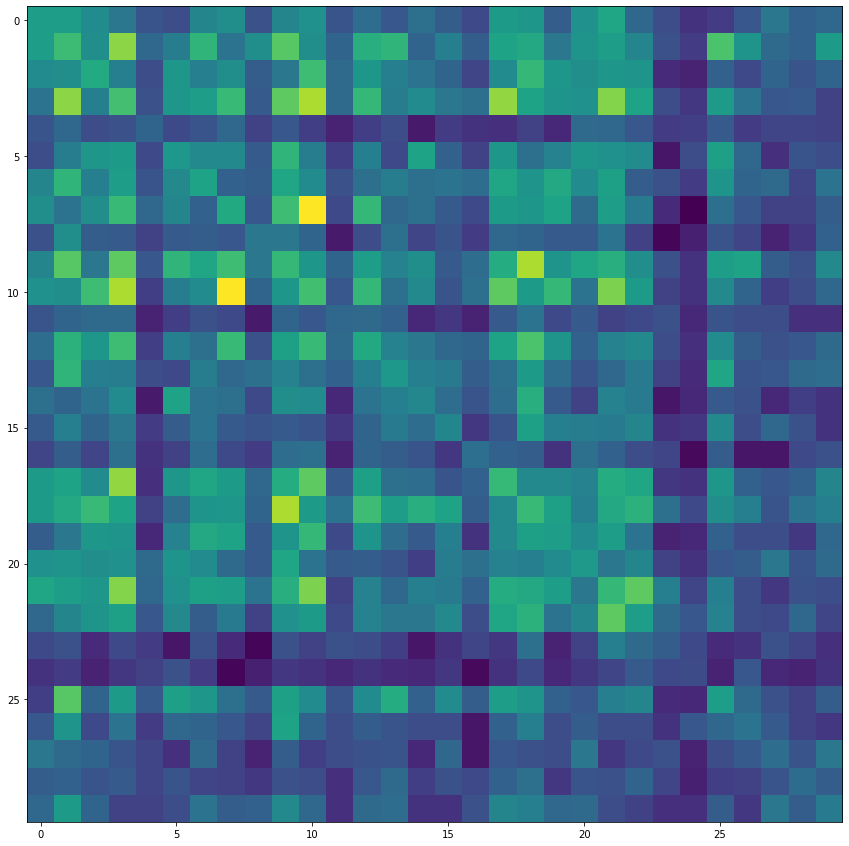

In [63]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(b)